In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("sms+spam+collection\SMSSpamCollection", sep="\t",names = ["label","raw text"]) 
df.to_csv("output.csv", index=False)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\kanih\AppData\Local\Temp\ipykernel_13164\917832962.py:1: SyntaxWarning: invalid escape sequence '\S'
  df = pd.read_csv("sms+spam+collection\SMSSpamCollection", sep="\t",names = ["label","raw text"])


In [14]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [17]:
# Define preprocessing parameters
max_words = 5000  # Vocabulary size
max_len = 100  # Maximum sequence length

# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['raw text'])  # Fit tokenizer on text column
sequences = tokenizer.texts_to_sequences(df['raw text'])  # Convert to sequences

# Padding sequences to a fixed length
X = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)
y = df['label'].values  # Labels

# Print preprocessing info
print("\nPreprocessing Info:")
print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
print(f"Sequence length: {max_len}")
print(f"Total samples: {len(X)}")



Preprocessing Info:
Vocabulary size: 9010
Sequence length: 100
Total samples: 5572


In [18]:
# Define vocabulary size
vocab_size = min(len(tokenizer.word_index) + 1, max_words)

# Functional API Model
inputs = tf.keras.layers.Input(shape=(max_len,))
x = tf.keras.layers.Embedding(vocab_size, 128)(inputs)
x = tf.keras.layers.SimpleRNN(64, return_sequences=True)(x)
x = tf.keras.layers.SimpleRNN(32)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 656,001 (2.50 MB)

 Trainable params: 656,001 (2.50 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8096 - loss: 0.4417 - val_accuracy: 0.9812 - val_loss: 0.0732
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9832 - loss: 0.0937 - val_accuracy: 0.9839 - val_loss: 0.0507
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9944 - loss: 0.0380 - val_accuracy: 0.9892 - val_loss: 0.0384
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9997 - loss: 0.0149 - val_accuracy: 0.9919 - val_loss: 0.0479
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9987 - loss: 0.0177 - val_accuracy: 0.9883 - val_loss: 0.0525


In [27]:
# Make Predictions
def predict_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])  # Convert text to sequence
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=max_len)  # Pad sequence
    prediction = model.predict(padded)[0][0]  # Get prediction score

    return {
        'text': text,
        'sentiment': 'Spam' if prediction > 0.5 else 'Ham',
        'confidence': float(prediction if prediction > 0.5 else 1 - prediction)
    }

# Example messages for prediction
test_messages = [
    "Congratulations! You've won a free iPhone. Claim now!",
    "Hey, let's catch up tomorrow.",
    "Your bank account has been locked due to suspicious activity. Click here to resolve.",
    "Meeting at 5 PM. Don't be late!"
]

# Predict and print results
for msg in test_messages:
    result = predict_sentiment(msg)
    print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
{'text': "Congratulations! You've won a free iPhone. Claim now!", 'sentiment': 'Spam', 'confidence': 0.9978142976760864}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
{'text': "Hey, let's catch up tomorrow.", 'sentiment': 'Ham', 'confidence': 0.9999581000811304}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
{'text': 'Your bank account has been locked due to suspicious activity. Click here to resolve.', 'sentiment': 'Ham', 'confidence': 0.9996690319676418}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
{'text': "Meeting at 5 PM. Don't be late!", 'sentiment': 'Ham', 'confidence': 0.9999506767962885}


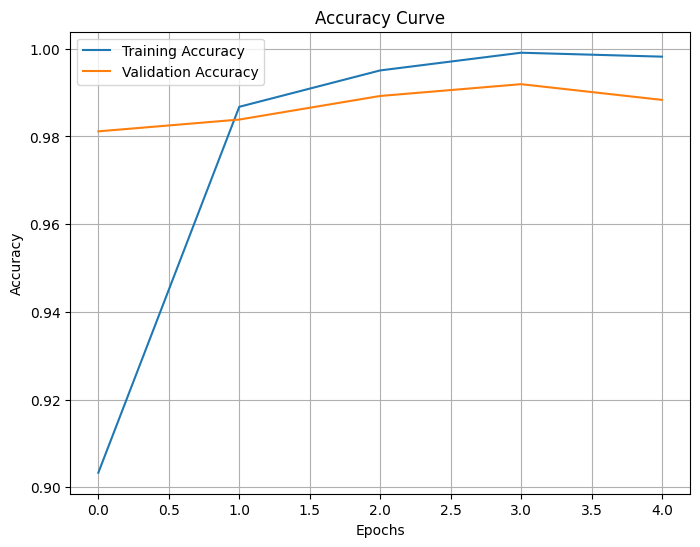

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

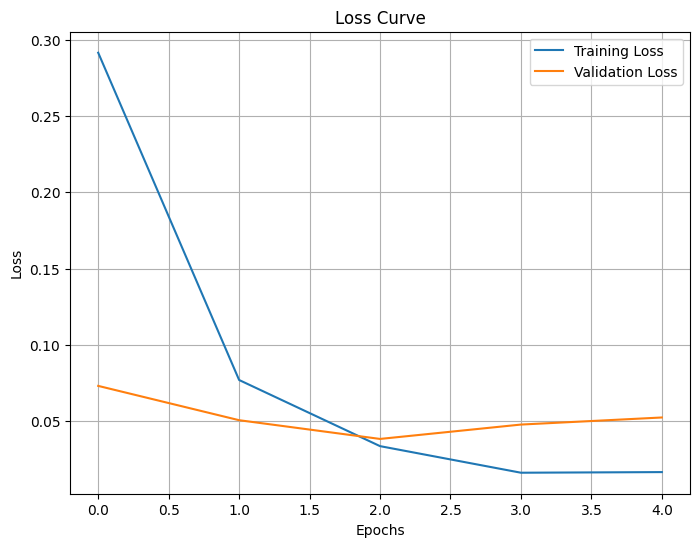

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()